In [98]:
import tensorflow as tf
import os
import pandas as pd
import random
from tensorflow.contrib.rnn import BasicLSTMCell, LSTMStateTuple, GRUCell, DropoutWrapper
from tensorflow.contrib.layers import fully_connected

In [11]:
import numpy as np

In [2]:
files = os.listdir(path='../../logs')

In [3]:
states, next_states, rewards, actions = [], [], [], []

In [4]:
for f in files:
    if 'next_state' in f:
        df= pd.read_csv('../../logs/'+f, index_col=0)
        next_states.append(df)
    elif 'state' in f:
        df= pd.read_csv('../../logs/'+f, index_col=0)
        states.append(df)
    elif 'action' in f:
        df= pd.read_csv('../../logs/'+f, index_col=0)
        actions.append(df)

In [113]:
tf.reset_default_graph()
state = tf.placeholder('float32', shape = [None, 41])
cell = GRUCell(num_units=h_size)

In [114]:
out, state_out = tf.nn.dynamic_rnn(cell = cell, inputs=tf.expand_dims ( state , [ 0 ] ), dtype='float32')

In [115]:
state_out

<tf.Tensor 'rnn/while/Exit_2:0' shape=(?, 128) dtype=float32>

In [147]:
h_size = 128
tf.reset_default_graph()
state = tf.placeholder('float32', shape = [None, 41])
action = tf.placeholder('float32', shape = [None, 18])
droput = 0.2

def lstm_test(state, h_size, dropout=0.8):
    
    
    cell = BasicLSTMCell ( h_size, activation=tf.nn.tanh)
    
#     cell = tf.contrib.rnn.DropoutWrapper(cell, output_keep_prob=1.0 - dropout)

#     cell = GRUCell(num_units=h_size)

    step_size = tf.shape ( state )[ :1 ]

    c_in = tf.placeholder ( 'float32' , [ 1 , cell.state_size.c ] , name='c' )
    h_in = tf.placeholder ( 'float32' , [ 1 , cell.state_size.h ] , name='h' )

    init = LSTMStateTuple ( c_in , h_in )
    
    out , state_out = tf.nn.dynamic_rnn ( cell=cell , initial_state=init , inputs=tf.expand_dims ( state , [ 0 ] ) ,
                                          sequence_length=step_size )
    
    out, c_out = tf.nn.dynamic_rnn(cell = cell, inputs=tf.expand_dims ( state , [ 0 ] ), dtype='float32')
    c_out , h_out = state_out
    state_out = [ c_out[ :1 , : ] , h_out[ :1 , : ] ]
    
    lstm_output = tf.reshape ( out , [ -1 , h_size ] )

    return lstm_output, c_in, h_in

def fc_test(state,h_size):
    h1 = fully_connected( inputs=state, num_outputs=h_size, activation_fn=tf.nn.elu)
    h1 = fully_connected( inputs=h1, num_outputs=h_size, activation_fn=tf.nn.elu)
    
    return fully_connected(h1, h_size, activation_fn=tf.nn.elu)


out = fc_test(state,h_size)
# out, c_in, h_in = lstm_test(state, h_size)
mu_hat = fully_connected(out, 18)

# tf.nn.softmax_cross_entropy_with_logits(logits, labels, name=None)

# loss = -tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=mu_hat, labels=action))
loss = tf.reduce_mean(tf.squared_difference(mu_hat, action), name = 'loss')
train = tf.train.AdamOptimizer(learning_rate= 1e-4).minimize(loss)

In [148]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [151]:
losses = []
for p in range(3000):
    idx = np.random.randint(500)
    
    state_batch = states[idx].as_matrix()
    action_batch = actions[idx].as_matrix()
    
    l, _ = sess.run([loss, train], feed_dict = {
        state:state_batch,
        action:action_batch
#         c_in:np.zeros([1,h_size]),
#         h_in:np.zeros([1,h_size])
    })
    losses.append(l)
    if p % 10 == 0:
        print(np.mean(losses), l)

0.195189 0.195189
0.260189 0.195293
0.249664 0.195234
0.259719 0.337883
0.268323 0.337751
0.264887 0.337767
0.264662 0.18754
0.266516 0.337746
0.264102 0.186107
0.260513 0.185707
0.25609 0.185146
0.255205 0.337749
0.251901 0.184357
0.253784 0.337883
0.253224 0.184121
0.251712 0.337883
0.251337 0.337883
0.250116 0.337747
0.252421 0.337883
0.25287 0.337747
0.254803 0.184821
0.255099 0.183909
0.255368 0.184101
0.255616 0.337883
0.254566 0.18468
0.25421 0.184667
0.255059 0.184706
0.255842 0.337748
0.256024 0.337883
0.255675 0.184669
0.255848 0.337748
0.257001 0.337749
0.256649 0.337883
0.256781 0.337883
0.257805 0.337748
0.257457 0.184659
0.257554 0.183866
0.258475 0.337748
0.257737 0.337883
0.259785 0.337749
0.259617 0.337883
0.260408 0.18629
0.260072 0.185403
0.259382 0.18422
0.260114 0.337747
0.259793 0.337883
0.259818 0.337747
0.26017 0.337748
0.260506 0.337883
0.260201 0.337883
0.261445 0.184689
0.260832 0.183758
0.259948 0.183819
0.259675 0.337883
0.259983 0.337748
0.260557 0.337748


In [ ]:
regularizer = tf.nn.l2_loss(weights)
loss = tf.reduce_mean(loss + beta * regularizer)

In [138]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N

In [146]:
l3 = np.copy(losses)

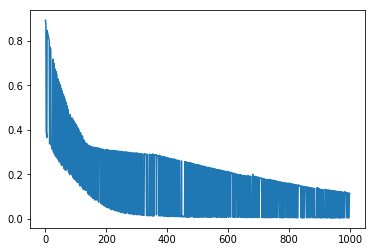

In [135]:
import matplotlib.pyplot as plt

plt.plot(losses)
plt.show()

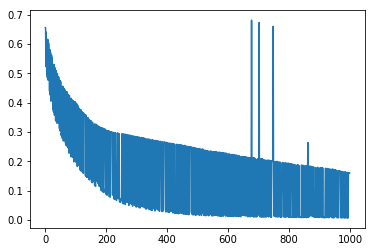

In [136]:
plt.plot(l2)
plt.show()

In [144]:
running_mean(l2,1000)

array([ 0.16560541], dtype=float32)

In [145]:
running_mean(losses,1000)

array([ 0.16114469], dtype=float32)